In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
df = pd.read_csv(r"E:\Tài liệu học\2024-2\Nhập môn Học máy và khai phá dữ liệu\Diabetes-Assessment-and-Prediction\Data\diabetes_dataset_processed.csv")
df.head(5)

,Insulin Levels,Age,BMI,Blood Pressure,Cholesterol Levels,Waist Circumference,Blood Glucose Levels,Weight Gain During Pregnancy,Pancreatic Health,Pulmonary Function,...,Physical Activity_Moderate,History of PCOS_No,History of PCOS_Yes,Previous Gestational Diabetes_No,Previous Gestational Diabetes_Yes,Steroid Use History_No,Steroid Use History_Yes,Family History_No,Family History_Yes,Target
0,40,44,38,124,201,50,168,18,36,76,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Steroid-Induced Diabetes
1,13,1,17,73,121,24,178,8,26,60,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,Neonatal Diabetes Mellitus (NDM)
2,27,36,24,121,185,36,105,15,56,80,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,Prediabetic
3,8,7,16,100,151,29,121,12,49,89,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,Type 1 Diabetes
4,17,10,17,103,146,33,289,2,10,41,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Wolfram Syndrome


In [3]:
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])
X = df.drop(columns=['Target'])
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\namkh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:38:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1070
           1       0.89      0.96      0.92      1072
           2       0.98      0.93      0.95      1072
           3       0.97      0.84      0.90      1194
           4       1.00      1.00      1.00      1018
           5       0.97      1.00      0.99      1089
           6       0.79      0.78      0.78      1053
           7       0.78      0.86      0.82      1048
           8       0.85      1.00      0.92      1123
           9       0.99      0.64      0.78      1083
          10       0.80      1.00      0.89      1064
          11       0.98      0.85      0.91      1063
          12       0.87      0.98      0.92      1051

    accuracy                           0.90     14000
   macro avg       0.91      0.90      0.90     14000
weighted avg       0.91      0.90      0.90     14000



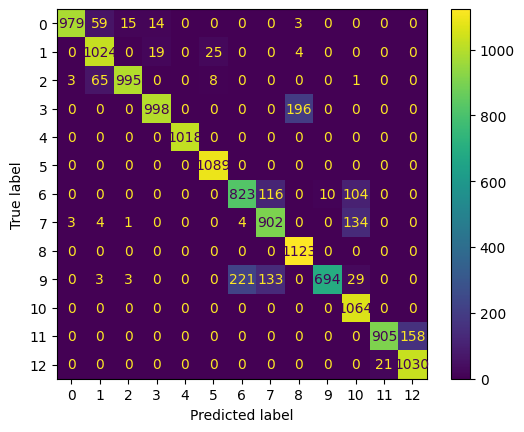

In [4]:
# Pipeline: scaler + XGBClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Có thể bỏ nếu dùng tree-based model, nhưng để đồng bộ với SVC
    ('classifier', XGBClassifier(
        objective='multi:softmax',
        num_class=13,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# Grid tham số cho XGBoost
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__scale_pos_weight': [1, 2, 5]  
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# scoring='precision_macro' để không bỏ sót người bệnh
# scoring='recall_macro' để không muốn dự đoán sai người khỏe mạnh là bị bệnh
# scoring='f1_macro' để cân bằng giữa precision và recall
best_model = GridSearchCV(pipeline, param_grid, cv=cv, scoring='precision_macro', n_jobs=-1)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [5]:
import joblib

model_path = r"E:\Tài liệu học\2024-2\Nhập môn Học máy và khai phá dữ liệu\Diabetes-Assessment-and-Prediction\Model\Built_model\xgboost_model.pkl"

joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

Model saved to E:\Tài liệu học\2024-2\Nhập môn Học máy và khai phá dữ liệu\Diabetes-Assessment-and-Prediction\Model\Built_model\xgboost_model.pkl


In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=60, ha='right')

plt.savefig(r'E:\Tài liệu học\2024-2\Nhập môn Học máy và khai phá dữ liệu\Diabetes-Assessment-and-Prediction\Result&Visualization\xgboost_heatmap.png', bbox_inches='tight')  
plt.close()